<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Magenta_arbitrary_style_transfer_model_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magenta arbitrary style transfer model conversion

This notebook outlines the steps required to create higher quality TF Lite models for style transfer. The [existing TF Lite style transfer models on TF Hub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) are based on MobileNetV2 based backbones. The ones we will be using are based on InceptionV3, so we can expect to have greater quality stylized images. An overview of these TF Lite models (MobileNetV2) is available [here](https://www.tensorflow.org/lite/models/style_transfer/overview). This notebook shows how to run inference with the TF Lite models converted here in [this notebook](https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Style_Transfer_Demo_InceptionV3_Dynamic_Shape.ipynb). [This notebook](https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/Style_Transfer_Demo_InceptionV3.ipynb) shows running inference with models that only support static shape. 

In [ ]:
# Authenticate
from google.colab import auth as google_auth
google_auth.authenticate_user()

This authentication is required to load the model files from a GCS Bucket that's **not public**. 

In [ ]:
# TensorFlow imports
!pip uninstall -q -y tensorflow
!pip install -q tf-nightly

import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 322.8MB 47kB/s 
     |████████████████████████████████| 6.8MB 47.2MB/s 
     |████████████████████████████████| 460kB 21.3MB/s 
2.4.0-dev20200716


A runtime restart might be required if the version does not come as `*-dev*`. The authentication step at the top also needs to be executed if the runtime restarted. 

In [ ]:
#@title Select network backbone

model_type = 'original' #@param ["original", "mobile"]
#@markdown - Original network (InceptionV3, alpha=1)
#@markdown - Small (MobileNetV2, alpha=0.25)

# Define saved model path
style_predict_network = 'gs://mobile-ml-wg/arbitrary_style_transfer/{}/SavedModel/predict'.format(model_type)
style_transform_network = 'gs://mobile-ml-wg/arbitrary_style_transfer/{}/SavedModel/transfer'.format(model_type)

## Dynamic range quantization

In [ ]:
# Dynamic range quantization
def convert_tflite_model_dynamic(saved_model_path, tflite_path, type='style_predict'):
    model = tf.saved_model.load(saved_model_path)
    concrete_func = model.signatures[
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    print(concrete_func.inputs)
    if type == 'style_predict':
        concrete_func.inputs[0].set_shape([1, 256, 256, 3])
    
    # if you'd prefer static shape in your models just uncomment this block
    # else:
    #     for input in concrete_func.inputs:
    #         if input.name == 'content_image:0':
    #             input.set_shape([1, 384, 384, 3])
    #         elif input.name == 'Conv/BiasAdd:0':
    #             input.set_shape([1, 1, 1, 100])

    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_model = converter.convert()

    with tf.io.gfile.GFile(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print('Quantized model:', tflite_path, 
        'Size:', len(tflite_model) / 1024, "kb")

The following code block is needed to ensure the the input tensor shapes get allocated to the right input tensors:

```python
for input in concrete_func.inputs:
    if input.name == 'content_image:0':
        input.set_shape([1, 384, 384, 3])
    elif input.name == 'Conv/BiasAdd:0':
        input.set_shape([1, 1, 1, 100])
```

**Update**: With `tf-nightly` this issue should get fixed. TF Lite now also supports dynamic shapes. 

In [ ]:
# Style predict network
convert_tflite_model_dynamic(style_predict_network, 'style_predict_hybrid.tflite')

[<tf.Tensor 'style_image:0' shape=(None, None, None, 3) dtype=float32>]
Quantized model: style_predict_hybrid.tflite Size: 9085.0625 kb


Ignore the warnings. 

In [ ]:
# Style transfer network
convert_tflite_model_dynamic(style_transform_network, 'style_transfer_hybrid.tflite', type='style_transfer')

[<tf.Tensor 'Conv/BiasAdd:0' shape=(None, 1, 1, 100) dtype=float32>, <tf.Tensor 'content_image:0' shape=(None, None, None, 3) dtype=float32>]
Quantized model: style_transfer_hybrid.tflite Size: 2085.46875 kb


## Float16 quantization

In [ ]:
# Float16 quantization
def convert_tflite_model_dynamic(saved_model_path, tflite_path, type='style_predict'):
    model = tf.saved_model.load(saved_model_path)
    concrete_func = model.signatures[
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    print(concrete_func.inputs)
    if type == 'style_predict':
        concrete_func.inputs[0].set_shape([1, 256, 256, 3])
    else:
        for input in concrete_func.inputs:
            if input.name == 'content_image:0':
                input.set_shape([1, 384, 384, 3])
            elif input.name == 'Conv/BiasAdd:0':
                input.set_shape([1, 1, 1, 100])

    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()

    with tf.io.gfile.GFile(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print('Quantized model:', tflite_path, 
        'Size:', len(tflite_model) / 1024, "kb")

We are **not** going with dynamic shapes in case of this quantization scheme since TF Lite GPU delegate does not yet support that. 

In [ ]:
# Style predict network
convert_tflite_model_dynamic(style_predict_network, 'style_predict_f16.tflite')

[<tf.Tensor 'style_image:0' shape=(None, None, None, 3) dtype=float32>]
Quantized model: style_predict_f16.tflite Size: 17708.796875 kb


In [ ]:
# Style transfer network
convert_tflite_model_dynamic(style_transform_network, 'style_transfer_f16.tflite', type='style_transfer')

[<tf.Tensor 'Conv/BiasAdd:0' shape=(None, 1, 1, 100) dtype=float32>, <tf.Tensor 'content_image:0' shape=(None, None, None, 3) dtype=float32>]
Quantized model: style_transfer_f16.tflite Size: 3888.0 kb


## Int8 quantization (requires representative dataset)

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
def parse_function(image_size, raw_image_key_name):
  """Generate parse function for parsing the TFRecord training dataset.
  Read the image example and resize it to desired size.
  Args:
    image_size: int, target size to resize the image to
    raw_image_key_name: str, name of the JPEG image in each TFRecord entry
  Returns:
    A map function to use with tf.data.Dataset.map() .
  """

  def func(example_proto):
    """A generator to be used as representative_dataset for TFLiteConverter."""
    image_raw = tf.io.parse_single_example(
        example_proto,
        features={raw_image_key_name: tf.io.FixedLenFeature([], tf.string)},
    )
    image = tf.image.decode_jpeg(image_raw[raw_image_key_name])
    image = tf.expand_dims(image, axis=0)
    image = tf.image.resize(image, (image_size, image_size)) # bilinear is default
    image = tf.squeeze(image, axis=0)
    image = image / 255.0
    return image

  return func

In [ ]:
def rgb_filter_function(image):
  """Filter function that only lets RGB images go through.
  Args:
    image: Tensor, the image tensor to be checked.
  Returns: bool, whether to keep the image or not.
  """
  shape = tf.shape(image)[2]
  return tf.math.equal(shape, 3)

In [ ]:
def get_calibration_dataset(style_image_size, style_dataset_file, 
                            content_image_size, imagenet_data_dir):
  """Generate calibration dataset from the training dataset.
  Args:
    style_image_size: int, image size to resize the style images to.
    style_dataset_file: str, path to the style images TFRecord file.
    content_image_size: int, image size to resize the training images to.
    imagenet_data_dir: str, path to the ImageNet data.
  Returns:
    (str, str) Path to the style dataset and content dataset for calibration.
  """

  # Load style dataset
  style_dataset = tf.data.TFRecordDataset(style_dataset_file)
  style_dataset = style_dataset.map(parse_function(style_image_size, 'image_raw'),
                                    num_parallel_calls= \
                                    tf.data.experimental.AUTOTUNE)
  style_dataset = style_dataset.filter(rgb_filter_function)

  # Load content dataset
  tf_record_pattern = os.path.join(imagenet_data_dir, '%s-*' % 'train')
  data_files = tf.io.gfile.glob(tf_record_pattern)
  content_dataset = tf.data.TFRecordDataset(data_files)
  content_dataset = content_dataset.map(
      parse_function(content_image_size, 'image/encoded'))
  content_dataset = content_dataset.filter(rgb_filter_function)

  return style_dataset, content_dataset

The above utilities come from [here](https://github.com/magenta/magenta/blob/master/magenta/models/arbitrary_image_stylization/arbitrary_image_stylization_convert_tflite.py). 

In [ ]:
# Create the datasets
style_dataset, content_dataset = get_calibration_dataset(256, 'gs://mobile-ml-wg/tfrecord/style_images/style_images.tfrecord', 
    384, 'gs://mobile-ml-wg/tfrecord/imagenet2012/')

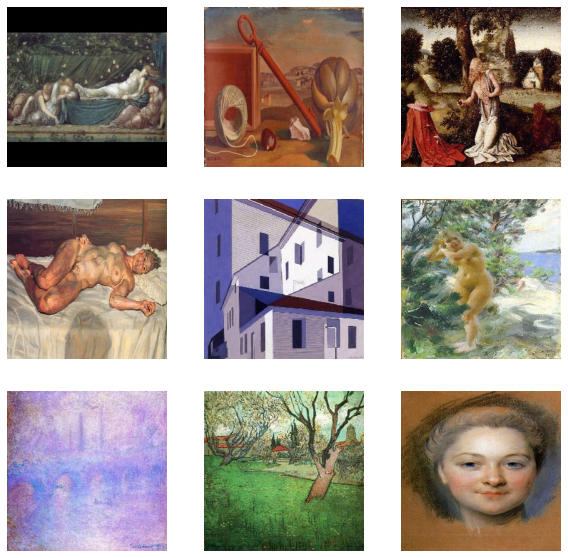

In [ ]:
# Visualize the style images
plt.figure(figsize=(10, 10))
for i, image in enumerate(style_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.axis('off')

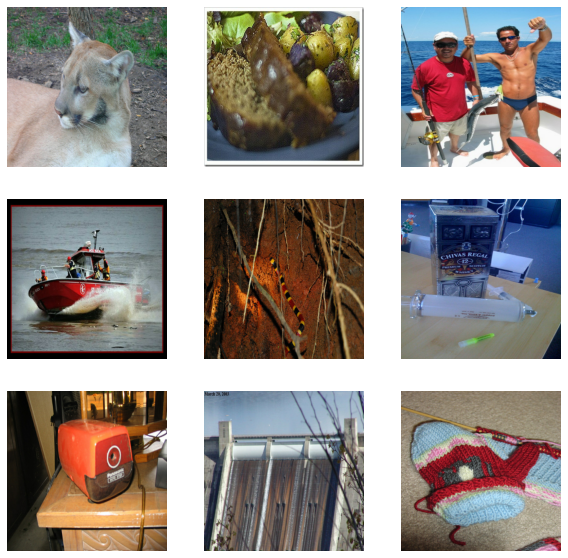

In [ ]:
# Visualize the content images
plt.figure(figsize=(10, 10))
for i, image in enumerate(content_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.axis('off')

### Inspecting the SavedModel graphs

In [ ]:
style_predict_graph = tf.saved_model.load(style_predict_network)
style_concrete_func = style_predict_graph.signatures['serving_default']
style_concrete_func.structured_outputs

{'style_bottleneck': <tf.Tensor 'Conv/BiasAdd:0' shape=(None, 1, 1, 100) dtype=float32>}

In [ ]:
style_transform_graph = tf.saved_model.load(style_transform_network)
transform_func = style_transform_graph.signatures['serving_default']
transform_func.structured_outputs

{'stylized_image': <tf.Tensor 'transformer/expand/conv3/conv/Sigmoid:0' shape=(None, None, None, 3) dtype=float32>}

In [ ]:
print(style_concrete_func.inputs) 
print(transform_func.inputs)

[<tf.Tensor 'style_image:0' shape=(None, None, None, 3) dtype=float32>]
[<tf.Tensor 'Conv/BiasAdd:0' shape=(None, 1, 1, 100) dtype=float32>, <tf.Tensor 'content_image:0' shape=(None, None, None, 3) dtype=float32>]


### Data generators for the representative datasets

In [ ]:
def style_images_rep():
    for image in style_dataset.take(10):
        yield [tf.expand_dims(image, 0)]

In [ ]:
def calculate_style_bottleneck(concrete_fn, images):
    return concrete_fn(tf.constant(images))['style_bottleneck']

In [ ]:
def transfer_rep(content_image_index, bottleneck_index):
  def transfer_rep_gen():
    # Create placeholders for the representative dataset
    representative_data = [None for i in range(len(transform_func.inputs))]
    
    # Get dummy style bottlenecks
    style_bottleneck_list = calculate_style_bottleneck(style_concrete_func, 
                                                       next(iter(style_dataset.batch(10))))

    for (i, content_image) in enumerate(content_dataset.take(10)):
        # Construct the representative dataset
        representative_data[content_image_index] = tf.expand_dims(content_image, 0)
        representative_data[bottleneck_index] = tf.expand_dims(style_bottleneck_list[i], 0)

        # Yield the representative dataset
        yield representative_data
  return transfer_rep_gen

In [ ]:
# Int8 quantization
def convert_tflite_model_dynamic(saved_model_path, tflite_path, type='style_predict'):
    model = tf.saved_model.load(saved_model_path)
    concrete_func = model.signatures[
        tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

    if type == 'style_predict':
        concrete_func.inputs[0].set_shape([1, 256, 256, 3])
    else:
        for index in range(len(concrete_func.inputs)):
            input = concrete_func.inputs[index]
            if input.name == 'content_image:0':
                # input.set_shape([1, 384, 384, 3]) # For static shape
                content_image_index = index
            # elif input.name == 'Conv/BiasAdd:0':
            else:
                # input.set_shape([1, 1, 1, 100]) # For static shape
                bottleneck_index = index

    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    if type == 'style_predict':
        converter.representative_dataset = style_images_rep
    else:
        converter.representative_dataset = transfer_rep(content_image_index, bottleneck_index)
    
    tflite_model = converter.convert()

    with tf.io.gfile.GFile(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print('Quantized model:', tflite_path, 
        'Size:', len(tflite_model) / 1024, "kb")

Apart from specifying the input tensor names, here we are specifying their indices as well:

```python
for index in range(len(concrete_func.inputs)):
input = concrete_func.inputs[index]
if input.name == 'content_image:0':
    input.set_shape([1, 384, 384, 3])
    content_image_index = index
elif input.name == 'Conv/BiasAdd:0':
    input.set_shape([1, 1, 1, 100])
    bottleneck_index = index
```

This is needed in order to ensure the inputs get populated to our representative dataset in the correct order. 

In [ ]:
# Style predict network
convert_tflite_model_dynamic(style_predict_network, 'style_predict_int8.tflite')

Quantized model: style_predict_int8.tflite Size: 9206.421875 kb


In [ ]:
# Style transfer network
convert_tflite_model_dynamic(style_transform_network, 
                             'style_transfer_int8.tflite', type='style_transfer')

Quantized model: style_transfer_int8.tflite Size: 2149.625 kb


## Acknowledgements

Huge thanks to **Khanh LeViet** for helping to work out the issues.